# E_05. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기  

----
목차  
1. 데이터 전처리  
2. 모델 선정  
3. 결과 저장 및 제출   
4. 회고록  
----  

학습을 위해 다음 링크의 코드를 활용하였습니다. https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12  

In [74]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import gc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm

### 1. 데이터 불러오기

In [75]:
train_data_path = join('C:\\DB\\kaggle_data', 'train.csv')
test_data_path = join('C:\\DB\\kaggle_data', 'test.csv')

In [76]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [77]:
print("train.csv. Shape: ",train.shape)
print("test.csv. Shape: ",test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6468, 20)


In [78]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 결측치 확인.

<AxesSubplot:>

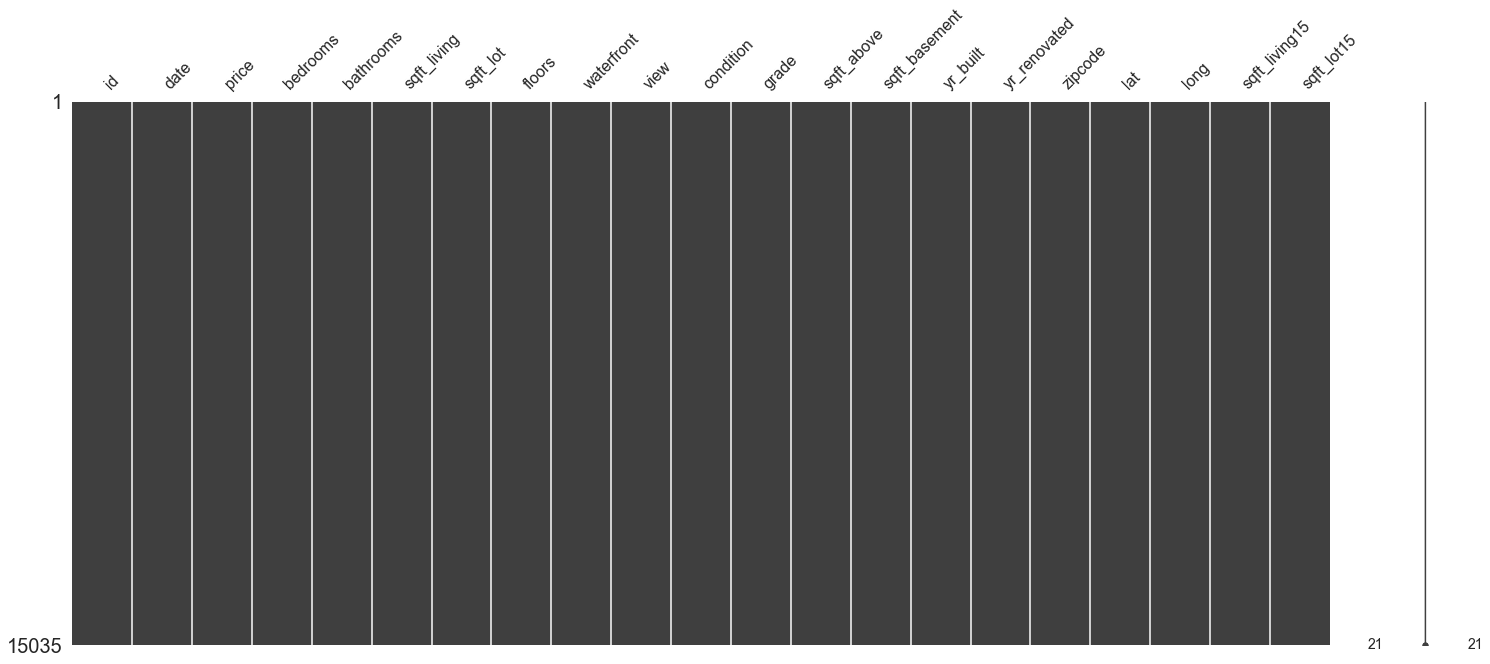

In [79]:
msno.matrix(train)

In [80]:
train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

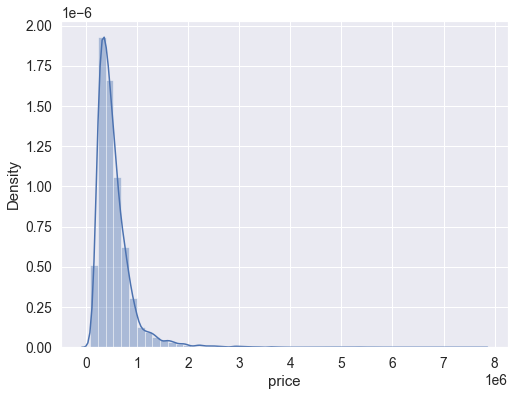

In [81]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

In [82]:
print("Skewness: %f" % train['price'].skew())
print("Kurtosis: %f" % train['price'].kurt())

Skewness: 4.290252
Kurtosis: 40.154919


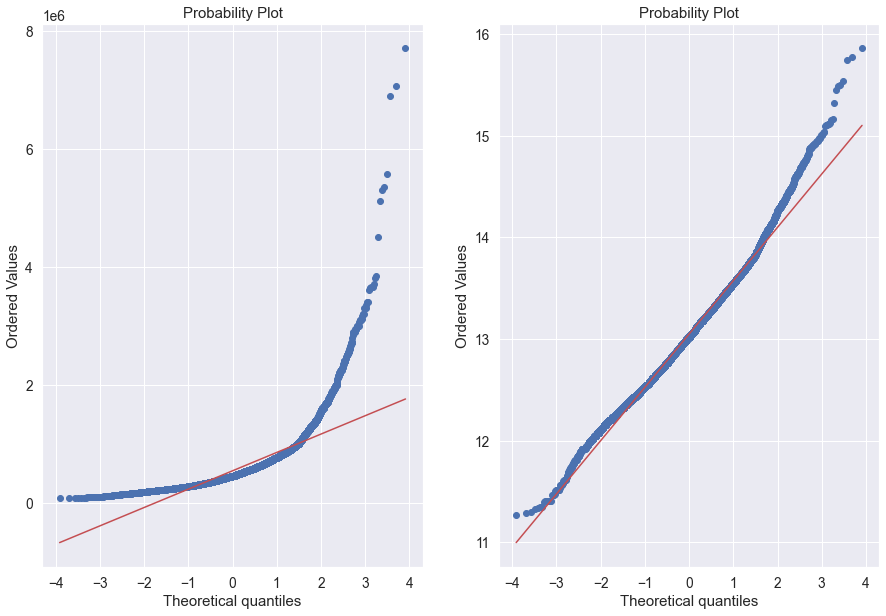

In [83]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(train['price']), plot=plt)

<AxesSubplot:xlabel='price', ylabel='Density'>

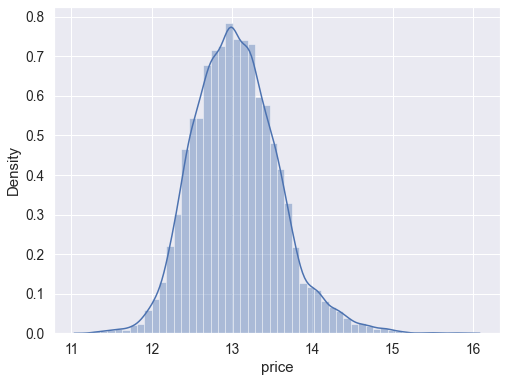

In [84]:
train['price'] = np.log1p(train['price'])
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

#### price column과의 상관관계 비교 및 제거

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode' 'date']


<AxesSubplot:>

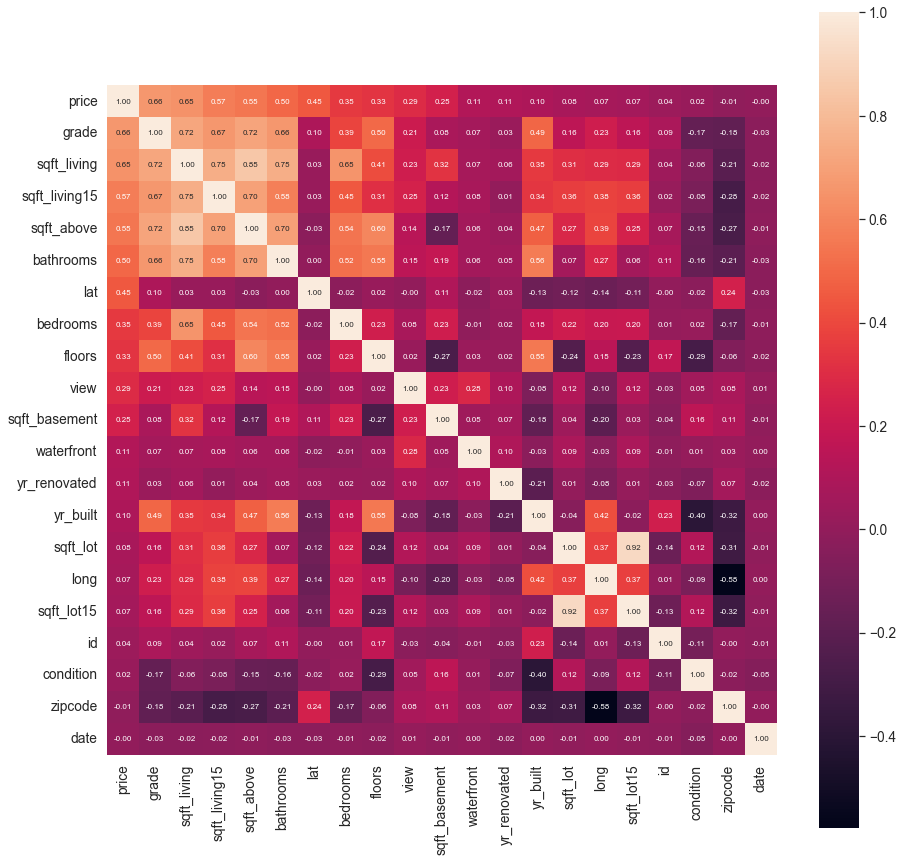

In [85]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21, columns='price').index # price과 correlation이 높은 column 내림차순
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(15,15))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

Spearman 상관은 두 계량형 변수 또는 순서형 변수 사이의 단순 관계를 평가.   
단순 관계에서 두 변수는 함께 변화하는 경향이 있지만 반드시 일정한 비율로 변화하는 것은 아님.  
Spearman 상관 계수는 원시 데이터가 아니라 각 변수에 대해 순위를 매긴 값을 기반으로 함.  
speraman 상관 계수를 통해 price와 관련이 큰 column들을 추려냄.  
상관 계수가 0.1이 안되는 7개의 항목을 제외시켜 보기로 함.

#### 이상치 확인 및 제거

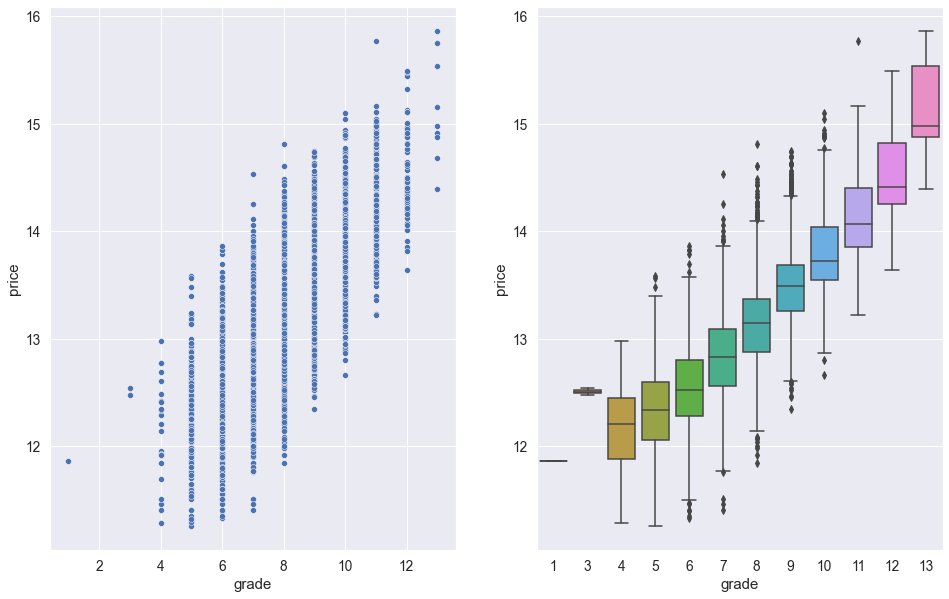

In [86]:
data = pd.concat([train['price'], train['grade']], axis=1)


fig = plt.figure(figsize = (16,10))

fig.add_subplot(1,2,1)
res = sns.scatterplot(x='grade', y="price", data=data)

fig.add_subplot(1,2,2)
res = sns.boxplot(x='grade', y="price", data=data)

In [87]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [88]:
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]

In [89]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [90]:
train = train.loc[train['id']!=2775]

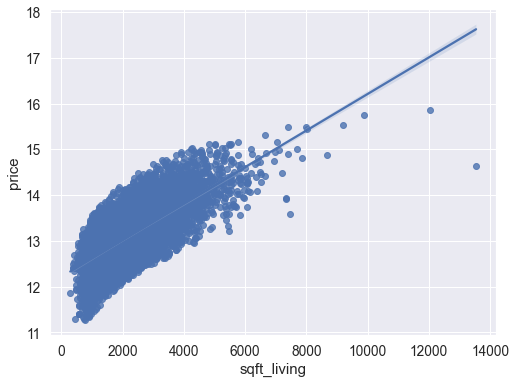

In [91]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [92]:
train.loc[(train['price']>14.5) & (train['sqft_living'] > 13000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [93]:
train = train.loc[train['id']!=8912]

In [94]:
y = train['price']
del train['price']
del train['sqft_lot']
del train['long']
del train['condition']
del train['id']
del train['sqft_lot15']
del train['zipcode']
del train['date']

print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'lat', 'sqft_living15'],
      dtype='object')


In [95]:
del test['sqft_lot']
del test['long']
del test['condition']
del test['id']
del test['sqft_lot15']
del test['zipcode']
del test['date']

In [96]:
print(test.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'lat', 'sqft_living15'],
      dtype='object')


#### 3. 모델 학습 및 테스트

In [97]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [98]:
random_state = 2022
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [99]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
get_scores(models, train, y)

,RMSE
RandomForestRegressor,179319.428914
GradientBoostingRegressor,176207.196482
LGBMRegressor,174796.643180
XGBRegressor,173755.891472


In [100]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=7, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [101]:
param_grid = {
    'n_estimators': [80,100],
    'max_depth': [10,25]
    }
my_GridSearch(xgboost, train, y, param_grid)


Fitting 7 folds for each of 4 candidates, totalling 28 fits


,max_depth,n_estimators,score,RMSLE
0,10,80,-0.043001,0.207366
1,10,100,-0.043416,0.208365
2,25,80,-0.045463,0.213220
3,25,100,-0.045463,0.213220


In [102]:
model = XGBRegressor(max_depth=10, n_estimators=80, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.233671, 12.898583, 14.131643, ..., 13.120628, 12.690883,
       13.005814], dtype=float32)

In [103]:
prediction = np.expm1(prediction)
prediction

array([ 558868.44,  399744.5 , 1371811.4 , ...,  499132.25,  324772.3 ,
        444991.9 ], dtype=float32)

#### 4. 결과 저장 및 제출.

In [104]:
data_dir = 'C:\\DB\\kaggle_data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

In [105]:
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [106]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.588684e+05
1,15036,3.997445e+05
2,15037,1.371811e+06
3,15038,3.004517e+05
4,15039,3.053552e+05


In [107]:
def save_submission(model, train, y, test, model_name, rmsle):
    
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print(submission_csv_path)

In [108]:
save_submission(model, train, y, test, 'xgb', rmsle='0.207366')

C:\DB\kaggle_data/submission_xgb_RMSLE_0.207366.csv


###회고록  

----  

캐글 Submission 스코어 : 153390.73579  
데이터 전처리는 분류모델의 성능을 올리지만, 무분별한 전처리는 역효과를 가져올 수 있다.  
상관관계가 낮다고 생각되는 column들을 지운 결과 오히려 성능이 나빠지는 결과를 초래했다.  
전처리 단계의 중요성을 실패를 통해 깨달을 수 있는 기회가 되었다.  
